# <center><h2><b>Q_impact project</b></h2></center>


\begin{equation}
      q = - \frac{\alpha_C }{ Z} \frac{Z + 0.24}{Z + 4.2} T^{\alpha_N} \frac{\partial T}{\partial x}
\end{equation}

**Configuration of the fit:**

In [13]:
N=8#Number of domains
fitoption=5 #Options of fitting:
            #1 - constant alphaC, alphaN = 2.5
            #2 - monomic alphaC, alphaN = 2.5
            #3 - constant alphaC, constant alphaN
            #4 - monomic alphaC, constant alphaN 
            #5 - Quadratic alphaC, alphaN = 2.5
            #6 - monomic alphaC, monomic alphaN
xmin = -1  
xmax = 1

In [28]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from scipy.interpolate import CubicSpline
import math
import sys


%matplotlib ipympl
#!!!
def import_from_git(filename):
    url=f'https://raw.githubusercontent.com/homijan/ML-student-projects/intro-ab/students/bogdaale/gd-profiles/{filename}'
    return url
import scienceplots
plt.style.use('science')
path='C:/Users/aleks/Projects/arameic-mishmash/Bachelor/Data'
#!!!


**Importing data**

In [15]:
x_Te, Te_raw = np.loadtxt(import_from_git('Te_gdhohlraum_cm_10ps_TekeV_interp.txt'), usecols=(0, 1), unpack=True)
x_ne, ne_raw = np.loadtxt(import_from_git('ne_gdhohlraum_cm_ne1e20cm3_interp.txt'), usecols=(0, 1), unpack=True)
x_Zbar, Zbar_raw = np.loadtxt(import_from_git('Zbar_gdhohlraum_cm_Z_interp.txt'), usecols=(0, 1), unpack=True)

x_Qloc, Qloc_raw = np.loadtxt(import_from_git('Q_gdhohlraum_microns_10ps_LocalWcm2.txt'), usecols=(0, 1), unpack=True)
x_Qimpact, Qimpact_raw = np.loadtxt(import_from_git('Q_gdhohlraum_microns_10ps_IMPACTWcm2.txt'), usecols=(0, 1), unpack=True)
x_Qsnb, Qsnb_raw = np.loadtxt(import_from_git('Q_gdhohlraum_microns_10ps_separatedsnbWcm2.txt'), usecols=(0, 1), unpack=True)

x_Qc7bBGK, Qc7bBGK_raw, Knx_raw = np.loadtxt(import_from_git('Q_gdhohlraum_cm_10ps_c7b-bgk-Wcm2-clogCHIC.txt'), comments='#',\
                                         delimiter=',', usecols=(0, 8, 6), unpack=True)
x_Qc7bAWBS, Qc7bAWBS_raw = np.loadtxt(import_from_git('Q_gdhohlraum_cm_10ps_c7b-awbs-Wcm2-clogCHIC.txt'), comments='#',\
                                      delimiter=',', usecols=(0, 8), unpack=True)

# changing units um->cm
x_Qloc/=1e4
x_Qimpact/=1e4
x_Qsnb/=1e4


**Here the cubic spline interpolation is implemented** so that all values have the same x-axis

In [16]:
xref = x_Te[np.logical_and(x_Te > xmin, x_Te < xmax)]

def getsub(f, x, xref):
    f_cs = CubicSpline(x, f)
    return f_cs(xref)

Te = getsub(Te_raw, x_Te, xref)
ne = getsub(ne_raw, x_ne, xref)
Zbar = getsub(Zbar_raw, x_Zbar, xref)
Qloc = getsub(Qloc_raw, x_Qloc, xref)
Qimpact = getsub(Qimpact_raw, x_Qimpact, xref)
Qsnb = getsub(Qsnb_raw, x_Qsnb, xref)
Qc7bBGK = getsub(Qc7bBGK_raw, x_Qc7bBGK, xref)
Knx = getsub(Knx_raw, x_Qc7bBGK, xref)
Qc7bAWBS = getsub(Qc7bAWBS_raw, x_Qc7bAWBS, xref)

### 3-th task
Evaluate the heat flux constant $k$ from the formula $q = -\frac{k}{Z} \frac{(Z + 0.24)}{ (Z + 4.2)} T^{2.5}\frac{\partial T}{\partial x}$ by matching the $Q_{loc}$ profile

In [17]:
#calculating Te gradient
gradTe=np.gradient(Te, xref)  
#!!! 3-th task
def fitQloc(X, k):
    #fit function for Qloc profile
    Z, T, gradT = X
    q = -(k/Z)*((Z+0.24)/(Z+4.2))*T**2.5*gradT
    return q
par3, cov3 = curve_fit(fitQloc, (Zbar, Te, gradTe), Qloc,  maxfev = 1000)
standev3=np.sqrt(np.diag(cov3))
kQSH = par3[0]
print(f'Constant from Qloc profile k = {par3[0]:.4e} ± {standev3[0]:.1e}')

Constant from Qloc profile k = 6.1480e+02 ± 3.4e-02


**Definition of fit function**

In [18]:
opts=pd.DataFrame(index=pd.Index(['useC','useX','useN','useXN','useX2','useXN1']))
opts['values']=np.full(6, True)
if fitoption in range(7):
    opts.iloc[:]=False
    opts.iloc[fitoption-1]=True
else:
    print(f'Unknown option {fitoption}')
    opts['useC']=True
    
    
def fitQimpact(X, alpha0, alpha1, alpha2, alpha3, alpha4):
    #fit function for Qloc profile
    x, Z, T, gradT = X
    if (opts.loc['useC'][0]):
        q = -(alpha0 * kQSH / Z) * ((Z + 0.24) / (Z + 4.2)) * T**2.5 * gradT 
    else:
        if (opts.loc['useX'][0]):
            q = ( -((alpha0 + alpha1 * x) * kQSH / Z) * ((Z + 0.24)/(Z+4.2)) *T**2.5 * gradT )
        else:
            if (opts.loc['useN'][0]):
                q = ( -(alpha0 * kQSH / Z) * ((Z + 0.24) / (Z + 4.2)) *T**(2.5 * 1.0 / (1.0 + np.exp(alpha3))) * gradT )
            else: 
                if (opts.loc['useXN'][0]):
                    q = ( -((alpha0 + alpha1 * x) * kQSH / Z) * ((Z + 0.24) / (Z + 4.2))* T**(2.5 * 1.0 / (1.0 + np.exp(alpha3))) * gradT )
                else: 
                    if (opts.loc['useX2'][0]):
                        q = ( -((alpha0 + alpha1 * x + alpha2 * x * x) * kQSH / Z) *((Z + 0.24) / (Z + 4.2)) * T**2.5 * gradT )
                    else:
                        if (opts.loc['useXN1'][0]):
                            q = ( -((alpha0 + alpha1 * x) * kQSH / Z) * ((Z + 0.24) / (Z + 4.2)) *\
                                 T**(2.5 * 1.0 / (1.0 + np.exp(alpha3 + alpha4 * x))) * gradT )
                        else:
                            print("Unknown loss function")
    return q
opts


,values
useC,False
useX,False
useN,False
useXN,False
useX2,True
useXN1,False


### 4&5-th task 
Evaluate "nonlocal" fitting constants $\alpha_C$ and $\alpha_N$ above $N$ subintervals  from the formula $q = -\frac{\alpha_C(x)}{Z} \frac{(Z + 0.24)}{ (Z + 4.2)} T^{\alpha_N(x)}\frac{\partial T}{\partial x}$ by matching $Q_{impact}$ profile



In [19]:
print("     For N = ", N, '\n')
# split the data we use in fit
split_Z = np.array_split(Zbar, N)
split_T = np.array_split(Te, N)
split_gradT = np.array_split(gradTe, N)
split_Qimpact = np.array_split(Qimpact, N)    #split the data we want to fit
split_x = np.array_split(xref, N)             #split the x axes to know at which subinterval we currently are
subfits = np.array([[],[]])                   #contain fit data for each subinterval
fitparameters=pd.DataFrame(index=['alpha0','alpha1', 'alpha2', 'alpha3', 'alpha4'])
for sub, _ in enumerate(split_x):             #fitting for each subinterval of xref
    if _[0]>1e-2:
        bound=[[-4e9,-4e9,-4e9,-4e9,-4e9 ],[4e9,4e9,4e9,4e9,4e9]]
    else:
        bound=[[-1e4,-1e4,-1e4,-1e4,-1e4 ],[1e4,1e4,1e4,1e4,1e4]]
    pars, covs = curve_fit(fitQimpact, (split_x[sub], split_Z[sub],split_T[sub], split_gradT[sub]), split_Qimpact[sub],  maxfev = 100000
                           ,bounds=bound)
    standevs = np.sqrt(np.diag(covs))
    if N<10:
        print(f'Pars in subinterval x in <{split_x[sub][0]:.3e} ; {split_x[sub][-1]:.3e}>:','\n',\
            f'alpha0 = {pars[0]:.2e} +- {standevs[0]:.2e}','\n',\
            f'alpha1 = {pars[1]:.2e} +- {standevs[1]:.2e}','\n',\
            f'alpha2 = {pars[1]:.2e} +- {standevs[1]:.2e}','\n',\
            f'alpha3 = {pars[1]:.2e} +- {standevs[1]:.2e}','\n',\
            f'alpha4 = {pars[1]:.2e} +- {standevs[1]:.2e}','\n')
    qsub = fitQimpact((split_x[sub], split_Z[sub], split_T[sub],split_gradT[sub]), *pars)
    subfits = np.concatenate((subfits, np.array([split_x[sub],qsub])), axis = 1)
    fitparameters[sub]=pars
print('Done')

     For N =  8 

Pars in subinterval x in <1.169e-03 ; 2.453e-02>: 
 alpha0 = 3.39e-01 +- 4.80e-03 
 alpha1 = 3.29e+01 +- 6.23e-01 
 alpha2 = 3.29e+01 +- 6.23e-01 
 alpha3 = 3.29e+01 +- 6.23e-01 
 alpha4 = 3.29e+01 +- 6.23e-01 

Pars in subinterval x in <2.454e-02 ; 4.790e-02>: 
 alpha0 = 5.61e-01 +- 1.46e-03 
 alpha1 = -4.39e+00 +- 8.01e-02 
 alpha2 = -4.39e+00 +- 8.01e-02 
 alpha3 = -4.39e+00 +- 8.01e-02 
 alpha4 = -4.39e+00 +- 8.01e-02 

Pars in subinterval x in <4.792e-02 ; 7.128e-02>: 
 alpha0 = 4.92e-01 +- 7.99e-04 
 alpha1 = 3.88e-01 +- 2.68e-02 
 alpha2 = 3.88e-01 +- 2.68e-02 
 alpha3 = 3.88e-01 +- 2.68e-02 
 alpha4 = 3.88e-01 +- 2.68e-02 

Pars in subinterval x in <7.129e-02 ; 9.465e-02>: 
 alpha0 = 2.14e-01 +- 1.49e-03 
 alpha1 = 8.18e+00 +- 3.58e-02 
 alpha2 = 8.18e+00 +- 3.58e-02 
 alpha3 = 8.18e+00 +- 3.58e-02 
 alpha4 = 8.18e+00 +- 3.58e-02 

Pars in subinterval x in <9.467e-02 ; 1.180e-01>: 
 alpha0 = -2.16e-01 +- 1.11e-02 
 alpha1 = 1.82e+01 +- 2.07e-01 
 alpha2 = 1.82

In [20]:
fitparameters.T.to_csv(f'{path}/nonsliding_fitopt{fitoption}.csv')

### 6-th task
Generalize the concept of subintervals to a concept of a sliding interval $<x_c - \Delta x/2, x_c + \Delta x/2>$ centered around point $x_c$ of size $\Delta x$

In [21]:
def getAlphas(x, Z, T, gradT, Qimpact,  width):  
    rad=0     #finds out how many points fits in (!)radius(!) range
    suma=0
    while suma<=width/2:
        suma=xref[rad]-xref[0]
        rad+=1
    slide=pd.DataFrame(columns=['Start','Center', 'End','alphaC0', 'alphaC0_std', 'alphaC1', 'alphaC1_std', 'alphaC2', 'alphaC2_std',\
                                'alphaN0', 'alphaN0_std', 'alphaN1', 'alphaN1_std']) 
    for ind, _ in enumerate(x):
        if ind+2*rad>=len(x):
            break
        else:
            pars, covs = curve_fit(fitQimpact, (x[ind:ind+2*rad], Z[ind:ind+2*rad], T[ind:ind+2*rad], gradT[ind:ind+2*rad]),\
                                   Qimpact[ind:ind+2*rad],  maxfev = 100000, bounds=[[-4e8,-4e8,-4e8,-4e8,-4e8 ],\
                                                                                     [4e8,4e8,4e8,4e8,4e8]])
            standevs = np.sqrt(np.diag(covs))
            
            alphaC0=pars[0]
            alphaC0_std=standevs[0]
            alphaC1=pars[1]
            alphaC1_std=standevs[1]
            alphaC2=pars[2]
            alphaC2_std=standevs[2]
            alphaN0=pars[3]
            alphaN0_std=standevs[3]
            alphaN1=pars[4]
            alphaN1_std=standevs[4]


            slide.loc[len(slide.index)]=[x[ind], x[ind+rad], x[ind+2*rad], alphaC0, alphaC0_std, alphaC1,\
                                         alphaC1_std, alphaC2, alphaC2_std,alphaN0, alphaN0_std, alphaN1, alphaN1_std]
            
            if ind%500==0:
                print(f"We're done with {ind}/{len(x)-2*rad} points")
    print('Done')
    return(slide)

slides=getAlphas(xref, Zbar, Te, gradTe, Qimpact,50e-4)

We're done with 0/9730 points
We're done with 500/9730 points
We're done with 1000/9730 points
We're done with 1500/9730 points
We're done with 2000/9730 points
We're done with 2500/9730 points
We're done with 3000/9730 points
We're done with 3500/9730 points
We're done with 4000/9730 points
We're done with 4500/9730 points
We're done with 5000/9730 points
We're done with 5500/9730 points
We're done with 6000/9730 points
We're done with 6500/9730 points
We're done with 7000/9730 points
We're done with 7500/9730 points
We're done with 8000/9730 points
We're done with 8500/9730 points
We're done with 9000/9730 points
We're done with 9500/9730 points
Done


In [25]:
slides.to_csv(f'{path}/sliding_fitopt{fitoption}.csv')

### 7-th Task
Prepare regression data based on the concept of sliding interval. For a given point xc create a 3N+1 long vector datapoint = [Zi, Ti, gradTi, Qc], where N is the number of discrete points in the deltax-interval and Qc is the value of Qimpact at xc. For each discrete position xc in (min(x) + deltax/2, max(x) - deltax/2) store the datapoint vector as a row to the data matrix Qdata.

In [27]:
def get_data(x, Z, T, gradT, Kn, n, Qimp,   width):  
    rad=0     #finds out how many points fits in (!)radius(!) range
    s=0
    while s<=width/2:
        s=xref[rad]-xref[0]
        rad+=1
    
    Qdata=np.empty((0,2*rad*5+3), int) #2*rad -  #of points in interval *5 - for each phsy quantity +3 - for three points of Qimp
    print(f'Row length is {10*rad+3}') #2*5{x,Z,T,gradT,Kn,N} + 3{qimpact}
    print(f'Number of rows {len(x)-2*rad+1}')
    
    x_c=np.array([]) #saves coordinate of center to index result array 
    
    for ind, _ in enumerate(x):  #x_min=x[ind], x_max=x[ind+2*rad], x_c=x[ind+rad]
        datapoint=np.array([])          
        if ind+2*rad>=len(x)+1:
            break    
        
        else:
            datapoint=np.append(datapoint,Z[ind:ind+2*rad]) #append all Zbar in xmin-xmax
            datapoint=np.append(datapoint,T[ind:ind+2*rad]) #append all Te in xmin-xmax
            datapoint=np.append(datapoint,gradT[ind:ind+2*rad]) #append all gradTe in xmin-xmax
            datapoint=np.append(datapoint,Kn[ind:ind+2*rad]) #append all Knudsen number in xmin-xmax
            datapoint=np.append(datapoint,n[ind:ind+2*rad]) #append all gradTe in xmin-xmax
            datapoint=np.append(datapoint,Qimp[ind+rad-1])
            datapoint=np.append(datapoint,Qimp[ind+rad]) #append Qimpact in x_c
            datapoint=np.append(datapoint,Qimp[ind+rad+1])
            Qdata=np.append(Qdata,[datapoint], axis=0)
            x_c=np.append(x_c,x[rad+ind])                     #will be used as index column for Qdata
            
            if ind%500==0:
                print(f"We're done with {ind}/{len(x)-2*rad+1} points") 
    
    #Naming of columns 
    column_names=[]
    for _,name in enumerate(['Z', 'T', 'gradT', 'Kn', 'n']):
        for i in range(2*rad):
            column_names=np.append(column_names,f'{name}_{i}')
    column_names=np.append(column_names,['Qimpact_c-1','Qimpact_c','Qimpact_c+1'])
    
    df_Qdata=pd.DataFrame(Qdata, columns=column_names, index=x_c)
    print('Done')
    return(df_Qdata)

Qdata=get_data(xref, Zbar, Te, gradTe, Knx, ne, Qimpact, 50e-4)

Row length is 1353
Number of rows 9731
We're done with 0/9731 points
We're done with 500/9731 points
We're done with 1000/9731 points
We're done with 1500/9731 points
We're done with 2000/9731 points
We're done with 2500/9731 points
We're done with 3000/9731 points
We're done with 3500/9731 points
We're done with 4000/9731 points
We're done with 4500/9731 points
We're done with 5000/9731 points
We're done with 5500/9731 points
We're done with 6000/9731 points
We're done with 6500/9731 points
We're done with 7000/9731 points
We're done with 7500/9731 points
We're done with 8000/9731 points
We're done with 8500/9731 points
We're done with 9000/9731 points
We're done with 9500/9731 points
Done


In [29]:
Qdata

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,...,n_263,n_264,n_265,n_266,n_267,n_268,n_269,Qimpact_c-1,Qimpact_c,Qimpact_c+1
0.003694,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,...,4.661122e+20,4.661157e+20,4.661192e+20,4.661227e+20,4.661262e+20,4.661298e+20,4.661333e+20,7.749012e+11,7.788372e+11,7.827731e+11
0.003712,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,...,4.661157e+20,4.661192e+20,4.661227e+20,4.661262e+20,4.661298e+20,4.661333e+20,4.661369e+20,7.788372e+11,7.827731e+11,7.867089e+11
0.003731,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,...,4.661192e+20,4.661227e+20,4.661262e+20,4.661298e+20,4.661333e+20,4.661369e+20,4.661405e+20,7.827731e+11,7.867089e+11,7.906447e+11
0.003750,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,...,4.661227e+20,4.661262e+20,4.661298e+20,4.661333e+20,4.661369e+20,4.661405e+20,4.661441e+20,7.867089e+11,7.906447e+11,7.945804e+11
0.003768,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,1.999184,...,4.661262e+20,4.661298e+20,4.661333e+20,4.661369e+20,4.661405e+20,4.661441e+20,4.661477e+20,7.906447e+11,7.945804e+11,7.985161e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.185570,37.325745,37.322640,37.319520,37.316387,37.313241,37.310081,37.306908,37.303722,37.300523,37.297311,...,7.972809e+21,7.976768e+21,7.980695e+21,7.984591e+21,7.988457e+21,7.992291e+21,7.996095e+21,1.884260e+12,1.872895e+12,1.861540e+12
0.185589,37.322640,37.319520,37.316387,37.313241,37.310081,37.306908,37.303722,37.300523,37.297311,37.294086,...,7.976768e+21,7.980695e+21,7.984591e+21,7.988457e+21,7.992291e+21,7.996095e+21,7.999869e+21,1.872895e+12,1.861540e+12,1.850194e+12
0.185607,37.319520,37.316387,37.313241,37.310081,37.306908,37.303722,37.300523,37.297311,37.294086,37.290849,...,7.980695e+21,7.984591e+21,7.988457e+21,7.992291e+21,7.996095e+21,7.999869e+21,8.003611e+21,1.861540e+12,1.850194e+12,1.838858e+12
0.185626,37.316387,37.313241,37.310081,37.306908,37.303722,37.300523,37.297311,37.294086,37.290849,37.287599,...,7.984591e+21,7.988457e+21,7.992291e+21,7.996095e+21,7.999869e+21,8.003611e+21,8.007323e+21,1.850194e+12,1.838858e+12,1.827531e+12


In [30]:
#Test of boundaries

print(Qdata['gradT_269'].iloc[-1]==gradTe[-1])
print(Qdata['n_0'].iloc[-1]==ne[9865-135])
print(Qdata['Z_0'].iloc[0]==Zbar[0])
print(Qdata['Z_269'].iloc[-1]==Zbar[-1])


True
True
True
True


In [31]:
Qdata.to_csv(f'{path}/QData.csv')

**Calculating mean and std for every quantity**

In [32]:
data_scaling=pd.DataFrame(index=['mean', 'std'], columns=['Z','T','gradT','Kn','n', 'Qimpact']) #will contain mean values and std
scaled_data=pd.DataFrame([Zbar,Te,gradTe,Knx,ne,Qimpact], index=['Z','T','gradT','Kn','n', 'Qimpact']).T 
# ^^^ All data of which I want to find mean and std 
for val in data_scaling.columns:
    data_scaling[val]['mean']=scaled_data[val].mean()
    data_scaling[val]['std']=scaled_data[val].std()
for col in scaled_data.columns:
    scaled_data[col]=(scaled_data[col]-data_scaling[col].loc['mean'])/data_scaling[col].loc['std']
data_scaling

,Z,T,gradT,Kn,n,Qimpact
mean,6.636804,2205.480397,-12173.390143,-0.021059,1121635206507455709184.0,27122346581215.433594
std,11.862872,688.061478,38357.521932,0.05132,1691621119773365764096.0,24775103321181.046875


In [33]:
data_scaling.to_csv(f'{path}/data_scaling_gradT.csv')

**Now i store scaled data in the same format as Qdata**

In [34]:
scaled_Qdata=get_data(xref, scaled_data['Z'],  scaled_data['T'],  scaled_data['gradT'],  scaled_data['Kn'],\
                      scaled_data['n'],  scaled_data['Qimpact'], 50e-4)

Row length is 1353
Number of rows 9731
We're done with 0/9731 points
We're done with 500/9731 points
We're done with 1000/9731 points
We're done with 1500/9731 points
We're done with 2000/9731 points
We're done with 2500/9731 points
We're done with 3000/9731 points
We're done with 3500/9731 points
We're done with 4000/9731 points
We're done with 4500/9731 points
We're done with 5000/9731 points
We're done with 5500/9731 points
We're done with 6000/9731 points
We're done with 6500/9731 points
We're done with 7000/9731 points
We're done with 7500/9731 points
We're done with 8000/9731 points
We're done with 8500/9731 points
We're done with 9000/9731 points
We're done with 9500/9731 points
Done


In [35]:
scaled_Qdata.to_csv(f'{path}/scaled_QData_gradT.csv')

**Plot parameters**

In [36]:
figuresize=6.5
import matplotlib.font_manager as fm
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['axes.linewidth'] = 0.5


**Electron temperature profile**

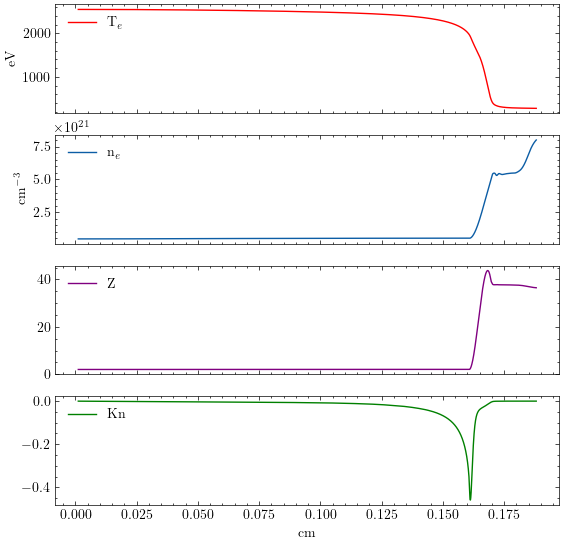

In [37]:
fig1, axs1 = plt.subplots(4, 1, figsize=(6.5,6.5), sharex=True)
axs1[0].plot(xref, Te, label="T$_e$", color='r')
axs1[0].set_ylabel('eV')
axs1[0].legend(loc='upper left')

axs1[1].plot(xref, ne, label="n$_e$")
axs1[1].set_ylabel('cm$^{-3}$')
axs1[1].legend()

axs1[2].plot(xref, Zbar, label="Z", color='purple')
axs1[2].legend()

axs1[3].plot(xref, Knx, color='green', label="Kn")
axs1[3].set_xlabel('cm')
axs1[3].legend(loc='upper left')


**Profile of fit function q**

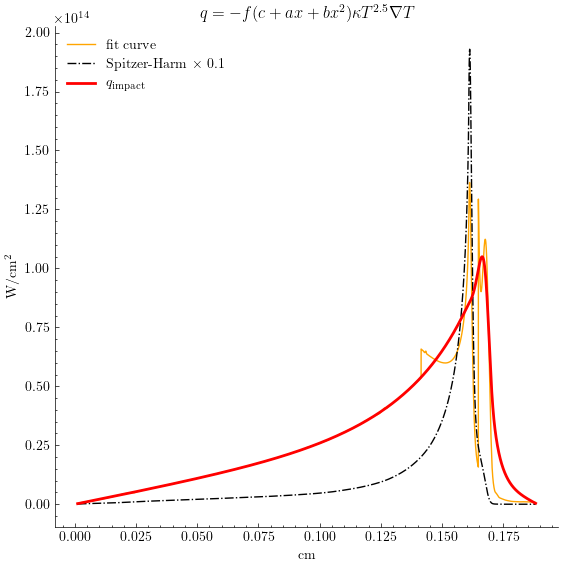

In [38]:
fig6, axs6 = plt.subplots(1, 1, figsize=(figuresize, figuresize))
axs6.plot(subfits[0,:],subfits[1,:], 'orange', label = f'fit curve')
axs6.plot(xref, Qloc/1e1, 'k-.', label = r'Spitzer-Harm $\times$ 0.1')
axs6.plot(xref, Qimpact, 'r', label="$q_\mathrm{impact}$", linewidth=2.0)
axs6.set_xlabel('cm')
axs6.set_ylabel('W/cm$^2$')
axs6.legend()
if (opts.loc['useC'][0]):
    axs6.set_title(r'  $q=- f(c) \kappa T^{2.5} \nabla T$')
else:
    if (opts.loc['useX'][0]):
        axs6.set_title(r'  $q=- f(c+ax) \kappa T^{2.5} \nabla T$')
    else:
        if (opts.loc['useN'][0]):
            axs6.set_title(r'  $q=- f(c) \kappa T^{\alpha(c)} \nabla T$')
        else:
            if (opts.loc['useXN'][0]):
                axs6.set_title(r'  $q=- f(c+ax) \kappa T^{\alpha(c)} \nabla T$')
            else:
                if (opts.loc['useX2'][0]):
                    axs6.set_title(r'  $q=- f(c+ax+bx^2) \kappa T^{2.5} \nabla T$')
                else:
                    if (opts.loc['useXN1'][0]):
                        axs6.set_title(r'  $q=- f(c+ax) \kappa T^{\alpha(c+ax)} \nabla T$')
                    else:
                        print("Unknown title option."); quit()

axs6.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True)
axs6.tick_params(axis='y',which='both',left=True,right=False)
axs6.spines['top'].set_visible(False)
axs6.spines['right'].set_visible(False)
mpl.rcParams['axes.linewidth'] = 0.01
plt.show()

**Heat flux profiles**

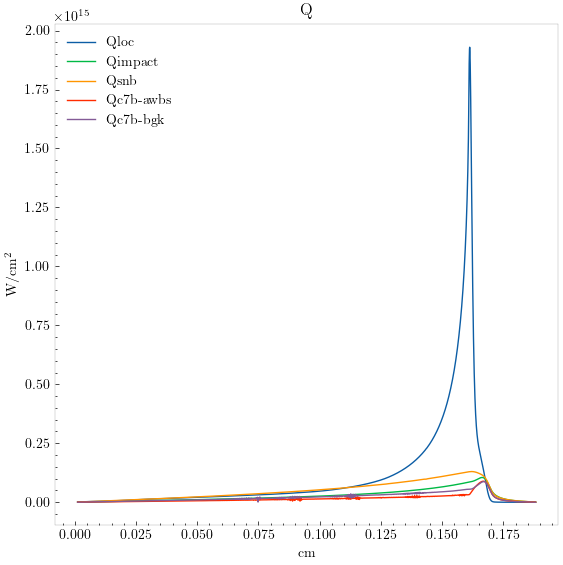

In [44]:
fig4, axs4 = plt.subplots(1, 1, figsize=(figuresize, figuresize))
axs4.plot(xref, Qloc, label="Qloc")
axs4.plot(xref, Qimpact, label="Qimpact")
axs4.plot(xref, Qsnb, label="Qsnb")
axs4.plot(xref, gaussian_filter1d(Qc7bAWBS,3), label="Qc7b-awbs")
axs4.plot(xref, gaussian_filter1d(Qc7bBGK, 3), label="Qc7b-bgk")
axs4.set_xlabel('cm')
axs4.set_ylabel('W/cm$^2$')
axs4.set_title('Q')

axs4.spines['bottom'].set_visible(True)
axs4.spines['left'].set_visible(True)

axs4.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True)
axs4.tick_params(axis='y',which='both',left=True,right=False)
mpl.rcParams['axes.linewidth'] = 0.2
axs4.legend(loc='upper left')